# 3rd part: Image and texts, with EasyCLEF

In [1]:
import os
import ParserEasyClef
import ParserCACM
import modeles
import numpy as np
import query
import evaluation
import clusterings
import matplotlib.pyplot as plt
# Auto reload the imported modules when running cells
%load_ext autoreload 
%autoreload 2

# Constants:

srcFolder = "easyCLEF08/"

# File that contains all documents
srcFile = "easyCLEF08_text.txt"
# File that contains all relevances for queries
relevantsFile = "easyCLEF08_gt.txt"
# File that contains all queries
qryFile = "easyCLEF08_query.txt"

easyClef_txt = os.path.join(srcFolder, srcFile)
easyClef_qry = os.path.join(srcFolder, qryFile)
easyClef_rel = os.path.join(srcFolder, relevantsFile)

In [2]:
import indexation 
import TextRepresenter

parser = ParserEasyClef.ParserEasyClef()
stemmer =  TextRepresenter.PorterStemmer()
idx = indexation.InMemoryIndex(easyClef_txt, 
                               parser, 
                               stemmer)
all_docs_id = idx.getDocsID()
print("All docs ID (%d):" % len(all_docs_id))
print(all_docs_id)

all_qry_id = []
allQueries = []
qp = query.QueryParserCACM(easyClef_qry, easyClef_rel)
qry = qp.nextQuery()
while qry is not None:
    allQueries.append(qry)
    all_qry_id.append(int(qry.getID()))
    qry = qp.nextQuery()
print("All qry ids (%d):" % len(all_qry_id))
print(all_qry_id)


All docs ID (2256):
['39291', '8379', '22875', '18680', '10140', '8290', '39684', '3736', '37596', '8193', '34138', '38020', '21760', '39696', '15074', '31192', '37529', '12273', '2560', '40188', '15764', '37610', '31864', '37597', '32481', '8941', '23166', '38739', '27682', '6639', '32695', '7947', '31217', '37262', '19490', '2764', '18942', '26685', '4313', '3741', '39318', '40542', '38016', '37483', '8174', '23108', '10281', '20514', '37678', '22323', '40215', '31844', '6923', '16638', '3901', '31622', '31515', '8940', '11511', '39699', '32816', '31543', '6973', '39258', '31702', '2285', '12143', '15672', '19575', '35678', '35962', '40666', '30507', '3589', '39190', '9797', '37368', '39794', '4979', '39313', '2693', '10973', '3636', '37667', '38198', '15144', '32799', '7426', '24766', '21327', '30845', '36043', '35807', '27662', '37237', '14160', '39678', '35621', '22665', '5175', '7928', '35682', '1515', '37567', '31883', '22145', '25661', '39236', '4022', '9910', '39133', '31541',

## Test baseline for some queries

In [3]:
modele_vect = modeles.Vectoriel(idx, modeles.TfidfWeighter(idx))
print("\n###### Testing QueryParserCACM: ###### ")
qp = query.QueryParserCACM(easyClef_qry, easyClef_rel)
qry = qp.nextQuery()
wantedId = [5, 3]
print("Searching for query", wantedId)
while qry is not None:
    if int(qry.getID()) in wantedId:
        print("Query")
        print(qry)
        qry_repr = stemmer.getTextRepresentation(qry.getText())
        dict_scores = modele_vect.getScores(qry_repr)
        list_scores = [(docId, score) for docId, score in dict_scores.items()]
        irlist = evaluation.IRList(qry, list_scores)
        eval_precAtN = evaluation.PrecisionNDocuments(irlist)
        eval_CRAtN = evaluation.ClusterRecallNDocuments(irlist)
        n = 20
        print("Precision at %d docs:" % n)
        print(eval_precAtN.eval(n, verbose=True))
        print("Cluster Recall at %d docs:" % n)
        print(eval_CRAtN.eval(n, verbose=True))

        print(20 * '-')
    qry = qp.nextQuery()
    
print("Done.")



###### Testing QueryParserCACM: ###### 
Searching for query [5, 3]
Query
Query {id=3, txt='religious statue in the foreground. Relevant images will show a statue of one (or more) religious figures such as gods, angels, prophets etc. from any kind of religion in the foreground. Non-religious statues like war memorials or monuments are not relevant. Images with statues that are not the focus of the image (like the front view of church with many small statues) are not relevant. The statues of Easter Island are not relevant as they do not have any religious background.
', relevances=[28, 3147, 4531, 4533, 4759, 4815, 4895, 4896, 4900, 6501, 10657, 10999, 14520, 15330, 15973, 16819, 16993, 19135, 19194, 19198, 19211, 19259, 20356, 20357, 22777, 23108, 25966, 30011, 35678, 35780, 35782, 35783, 36035, 36036]}
Precision at 20 docs:
Result:  3407
Result:  3414
Result:  4815
Relevant, found docs = 1
Result:  38216
Result:  38217
Result:  38218
Result:  38222
Result:  38221
Result:  38219
Result

## Test of clustering

In [4]:
kmeans = clusterings.KMeansClustering()
prCluster = modeles.PRClustering(idx, modele_vect, kmeans, nDocs=100)

qp = query.QueryParserCACM(easyClef_qry, easyClef_rel)
qry = qp.nextQuery()
wantedId = [5, 3]
print("Searching for query", wantedId)
while qry is not None:
    if int(qry.getID()) in wantedId:
        print("Query")
        print(qry)
        qry_repr = stemmer.getTextRepresentation(qry.getText())
        ranking = prCluster.getRanking(qry_repr, Nclusters=None)
        irlist = evaluation.IRList(qry, scores=None, ranking=ranking)
        eval_precAtN = evaluation.PrecisionNDocuments(irlist)
        eval_CRAtN = evaluation.ClusterRecallNDocuments(irlist)
        n = 20
        print("Precision at %d docs:" % n)
        print(eval_precAtN.eval(n, verbose=True))
        print("Cluster Recall at %d docs:" % n)
        print(eval_CRAtN.eval(n, verbose=True))

        print(20 * '-')
    qry = qp.nextQuery()
    
print("Done.")


Searching for query [5, 3]
Query
Query {id=3, txt='religious statue in the foreground. Relevant images will show a statue of one (or more) religious figures such as gods, angels, prophets etc. from any kind of religion in the foreground. Non-religious statues like war memorials or monuments are not relevant. Images with statues that are not the focus of the image (like the front view of church with many small statues) are not relevant. The statues of Easter Island are not relevant as they do not have any religious background.
', relevances=[28, 3147, 4531, 4533, 4759, 4815, 4895, 4896, 4900, 6501, 10657, 10999, 14520, 15330, 15973, 16819, 16993, 19135, 19194, 19198, 19211, 19259, 20356, 20357, 22777, 23108, 25966, 30011, 35678, 35780, 35782, 35783, 36035, 36036]}
Precision at 20 docs:
Result:  3407
Result:  3414
Result:  4815
Relevant, found docs = 1
Result:  38216
Result:  38221
Result:  35780
Relevant, found docs = 2
Result:  5109
Result:  35884
Result:  35885
Result:  39169
Result: 

## Plot for one query:

Searching for query 50
Query:  Query {id=50, txt='indoor photos of a church or cathedral. Relevant images will show an interior view of a church or cathedral. Images showing exterior views of churches or cathedrals are not relevant. Interior views of other buildings than fanes are not relevant.
', relevances=[2192, 2858, 3158, 4723, 4740, 4900, 4927, 4931, 5109, 8023, 8785, 9125, 11230, 13594, 14752, 15051, 15194, 15655, 15656, 15657, 16098, 16800, 17947, 19115, 23241, 30334, 38216, 38217, 38218, 38219, 38221, 38222, 38898, 39169]}


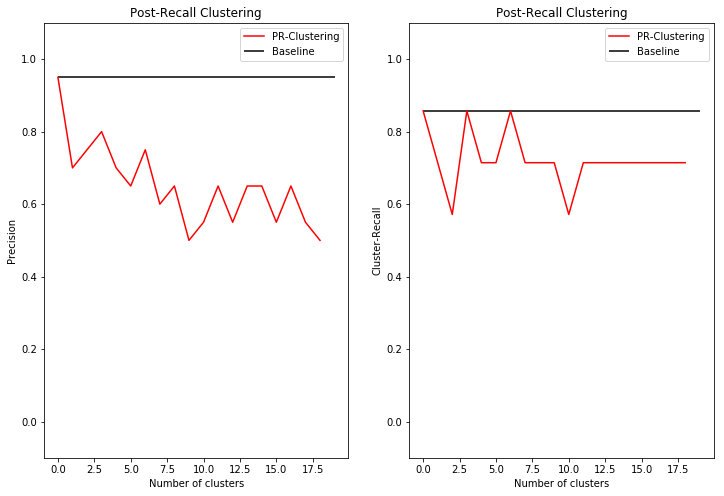

Done.


In [5]:
rand_qry_id = np.random.choice(all_qry_id)
print("Searching for query", rand_qry_id)
at = 20
nClusterRange = range(1, at)

# Searching the query
qp = query.QueryParserCACM(easyClef_qry, easyClef_rel)
qry = qp.nextQuery()
while qry is not None and int(qry.getID()) != rand_qry_id:
    qry = qp.nextQuery()
    
print("Query: ",qry)
qry_repr = stemmer.getTextRepresentation(qry.getText())

# Compute the baseline scores:
dict_scores = modele_vect.getScores(qry_repr)
list_scores = [(docId, score) for docId, score in dict_scores.items()]
irlist = evaluation.IRList(qry, list_scores)
eval_precAtN = evaluation.PrecisionNDocuments(irlist)
eval_CRAtN = evaluation.ClusterRecallNDocuments(irlist)
baseline_prec = eval_precAtN.eval(at, verbose=False)
baseline_CR   = eval_CRAtN.eval(at, verbose=False)
#print("Baseline: prec=%f, CR=%f" % (baseline_prec, baseline_CR))

# Compute the post-retrieval clustering:
precisions = []
CRs = []
for nCluster in nClusterRange:
    ranking = prCluster.getRanking(qry_repr, Nclusters=nCluster)
    irlist = evaluation.IRList(qry, scores=None, ranking=ranking)
    eval_precAtN = evaluation.PrecisionNDocuments(irlist)
    eval_CRAtN = evaluation.ClusterRecallNDocuments(irlist)
    prec = eval_precAtN.eval(at)
    CR = eval_CRAtN.eval(at, verbose=False)
    precisions.append(prec)
    CRs.append(CR)
    #print("%d clusters: prec=%f, CR=%f" % (nCluster, prec, CR))

plt.figure(figsize=(12,8))
plt.subplot(1,2,1)
plt.hlines(baseline_prec, xmin=0, xmax=at-1, label="Baseline")
plt.plot(precisions, "r", label="PR-Clustering")
plt.legend()
plt.title("Post-Recall Clustering")
plt.xlabel("Number of clusters")
plt.ylabel("Precision")
plt.ylim([-0.1, 1.1])

plt.subplot(1,2,2)
plt.hlines(baseline_CR, xmin=0, xmax=at-1, label="Baseline")
plt.plot(CRs, "r", label="PR-Clustering")
plt.legend()
plt.title("Post-Recall Clustering")
plt.xlabel("Number of clusters")
plt.ylabel("Cluster-Recall")
plt.ylim([-0.1, 1.1])

plt.show()

print("Done.")

# Benchmark

In [9]:
at = 20
benchmarkQueries = np.random.choice(allQueries, size=20, replace=False)

prCluster.setNDocs(100)
baseline_prec = []
baseline_CR = []
prCluster_prec = []
prCluster_CR = []

print("Query | Base prec. | PRC prec. | Delta  | Base CR | PRC CR | Delta")
print(70*'=')

for qry in benchmarkQueries:
    qry_repr = stemmer.getTextRepresentation(qry.getText())

    # Compute the baseline scores:
    dict_scores = modele_vect.getScores(qry_repr)
    list_scores = [(docId, score) for docId, score in dict_scores.items()]
    irlist = evaluation.IRList(qry, list_scores)
    basePrec = evaluation.PrecisionNDocuments(irlist).eval(at)
    baseCR = evaluation.ClusterRecallNDocuments(irlist).eval(at)
    baseline_prec.append(basePrec)
    baseline_CR.append(baseCR)
    
    # Compute the post-retrieval clustering:
    ranking = prCluster.getRanking(qry_repr, Nclusters=None, maxClusters=20)
    irlist = evaluation.IRList(qry, scores=None, ranking=ranking)
    prclusterPrec = evaluation.PrecisionNDocuments(irlist).eval(at)
    prclusterCR = evaluation.ClusterRecallNDocuments(irlist).eval(at)
    prCluster_prec.append(prclusterPrec)
    prCluster_CR.append(prclusterCR)
    print("%5s |    %.3f   |   %.3f   | %6.3f |  %.3f  | %.3f  | %6.3f" % 
          (qry.getID(), basePrec, prclusterPrec, prclusterPrec-basePrec, 
                        baseCR, prclusterCR, prclusterCR-baseCR))

        
print(70*'=')
meanBasePrec = np.mean(baseline_prec)
meanBaseCR = np.mean(baseline_CR)
meanPrcPrec = np.mean(prCluster_prec)
meanPrcCR = np.mean(prCluster_CR)
print("Mean  |    %.3f   |   %.3f   | %6.3f |  %.3f  | %.3f  | %6.3f" % 
          (meanBasePrec, meanPrcPrec, meanPrcPrec-meanBasePrec,
           meanBaseCR, meanPrcCR, meanPrcCR-meanBaseCR))    
print("Done.")

Query | Base prec. | PRC prec. | Delta  | Base CR | PRC CR | Delta
    2 |    0.350   |   0.300   | -0.050 |  0.600  | 0.600  |  0.000
   15 |    0.900   |   0.450   | -0.450 |  0.857  | 0.571  | -0.286
   24 |    0.000   |   0.050   |  0.050 |  0.000  | 0.250  |  0.250
   53 |    1.000   |   1.000   |  0.000 |  1.000  | 1.000  |  0.000
   16 |    0.600   |   0.700   |  0.100 |  0.261  | 0.304  |  0.043
   55 |    1.000   |   1.000   |  0.000 |  0.167  | 0.500  |  0.333
    5 |    0.850   |   0.650   | -0.200 |  0.625  | 0.375  | -0.250
   19 |    0.400   |   0.300   | -0.100 |  0.667  | 0.500  | -0.167
   50 |    0.950   |   0.500   | -0.450 |  0.857  | 0.714  | -0.143
   34 |    0.600   |   0.550   | -0.050 |  0.286  | 0.143  | -0.143
   59 |    0.450   |   0.350   | -0.100 |  1.000  | 0.500  | -0.500
   58 |    1.000   |   0.850   | -0.150 |  0.600  | 0.600  |  0.000
   12 |    0.500   |   0.350   | -0.150 |  1.000  | 1.000  |  0.000
   56 |    0.700   |   0.500   | -0.200 |  0.600 